### Creating the auxiliary input images

In [19]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import sys
sys.path.append("../")
from Workflow import Workflow


In [21]:
wf = Workflow()
Xtrain,ytrain,Xvalid,yvalid,Xtest,ytest = wf.load_data()

TypeError: load_data() missing 1 required positional argument: 'path'

In [ ]:

# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1. Load Elevation Data
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

# Dynamic path construction using os.path
data_path = os.path.join("..", "CNN_from_R", "images_for_CNN", "rainfall_raster_bound.tif")
rain, transform = load_rain_data(data_path)

# 2. Load the recharge data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge mean mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])


# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

C:\Users\chari\AppData\Local\Temp\ipykernel_23168\4279549286.py:25: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv("../Data/dat07_u.csv")


In [2]:
with rasterio.open(data_path) as src:
    transform = src.transform
    pixel_width = transform[0]   # `a` value: pixel size in x-direction
    pixel_height = -transform[4] # `e` value (negated because it's typically negative)
    print(f"Pixel size: {pixel_width} x {pixel_height}")

Pixel size: 0.05 x 0.05


#### Checking the centered images

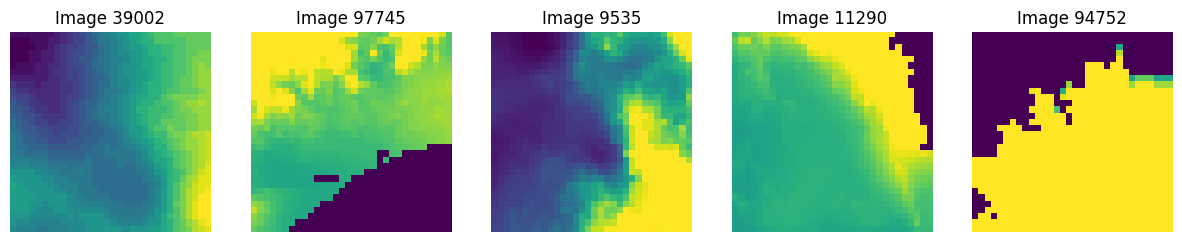

In [3]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann[idx], cmap="viridis")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [4]:
recharge_data = clor[['lat','lon','Rain mm/y', 'Recharge RC 50% mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]
# Assuming loc is a pandas DataFrame containing the columns: "Bng_easting", "Bng_northing", "elevation"
loc = recharge_data[['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]


In [10]:
np.mean(loc,axis=0)

lat                      -28.973431
lon                      139.272023
Rain mm/y                706.761733
rainfall_seasonality      10.526652
PET mm/y                2016.814237
elevation_mahd           186.894509
distance_to_coast_km     136.125708
ndvi_avg                   0.331609
clay_perc                 30.373843
soil_class                 9.034433
dtype: float64

In [ ]:
def standardize(data,mean,std):

    # Standardize the data (z-score normalization)
    return ((data - mean) / std).to_numpy()

In [37]:
recharge_data.shape[0]

98568

In [38]:
loc_ann[1]

array([ 0.54739326,  0.93351284, -0.13192523, -0.71667815,  0.66128752,
       -0.02089775,  0.15776049, -0.63913082,  1.42367874,  1.16900489])

### Our network

In [39]:
# Use neural network to learn relationship between terrain features and geochemistry ####

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros

np.random.seed(321)
fold_size = recharge_data.shape[0] // 10
test = np.random.choice(recharge_data.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(recharge_data.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(recharge_data.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train], loc_ann[train]]
x_val = [imgs_ann[val], loc_ann[val]]
x_test = [imgs_ann[test], loc_ann[test]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))


y_train = recharge_data['Recharge RC 50% mm/y'].astype(float)[train]
y_val = recharge_data['Recharge RC 50% mm/y'].astype(float)[val]
y_test = recharge_data['Recharge RC 50% mm/y'].astype(float)[test]

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(32, 32, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(10,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x[:, 0:1]), mean=x[:, 0:1], stddev=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)


In [40]:
# Define the model
model = models.Model(inputs=[conv_input, auxiliary_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error',  # Adjust loss function as needed
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 10, 10,    │      1,280 │ conv_input[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 10, 10,    │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_8 │ (None, 10, 10,    │          0 │ activation_14[0]… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 8, 8, 128) │          0 │ conv2d_9[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_9 │ (None, 8, 8, 128) │          0 │ activation_15[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 6, 6, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 6, 6, 128) │          0 │ conv2d_10[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 6, 6, 128) │          0 │ activation_16[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 4, 4, 128) │          0 │ conv2d_11[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1920)      │     21,120 │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 4, 4, 128) │          0 │ activation_17[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1920)      │          0 │ dense_6[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ spatial_dropout2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1920)      │          0 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,826,242 (10.78 MB)

 Trainable params: 2,826,242 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [42]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.18.0


#### Training

In [ ]:
#class for saving the best weights
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

save_best_model = SaveBestModel()

In [49]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 1000
epochs = 2

best_model_path = os.path.join(os.getcwd(), "models/best_model.h5")

checkpoint = ModelCheckpoint(
    filepath=best_model_path,    # Path to save the best model
    monitor='val_loss',          # Metric to monitor (can be 'val_loss', 'val_accuracy', etc.)
    save_best_only=True,         # Save only the best model
    save_weights_only=False,     # Save the entire model (not just weights)
    mode='min',                  # Mode: 'min' for minimizing loss, 'max' for maximizing accuracy
    verbose=1                    # Print a message when the model is saved
)
# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint]
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights


# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)


best_model = load_model(best_model_path)

# Predict with the best model
holdout = pd.DataFrame({'obs': y_test, 'preds': best_model.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
from sklearn.metrics import r2_score
import numpy as np

print(f"R squared = {round(r2_score(holdout['obs'], holdout['preds']), 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


7886/7886 - 102s - 13ms/step - accuracy: 0.0000e+00 - loss: 3019.5205 - val_accuracy: 0.0000e+00 - val_loss: 3567.0056


308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
R squared = 0.71
RMSE = 56.46


In [ ]:
# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

In [50]:
# Calculate and print R² score using numpy's corrcoef
try:
	r2_score = np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2
	print(f"R² Score: {r2_score:.3f}")
except Exception as e:
	print(f"Error calculating R² score: {e}")

R² Score: 0.710


: 

In [20]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [14]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject